## data preparation

In [19]:
import tensorflow as tf
print(tf.config.list_physical_devices())

import gc
class FreeMemory(tf.keras.callbacks.Callback):
    def __init__(self, log_freq=None):
        super().__init__()
        self.log_freq = log_freq
    def on_epoch_end(self, epoch, logs=None):
        if self.log_freq and epoch % self.log_freq == 0:
            print(f'epoch {epoch} ended, info: {logs}')
        tf.keras.backend.clear_session()
        gc.collect()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
POINTS_NUM = 10
CLASSES_NUM = 2

In [21]:
import numpy as np
points = np.load(f'/host/dissertation/proccessed_data/points_{POINTS_NUM}.npy')
q = np.load('/host/dissertation/proccessed_data/q.npy')

In [22]:
q[q == -1] = 0
q_labels = tf.one_hot(q, CLASSES_NUM)

## plotting

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def make_dataframe(fit_history):
    df = pd.DataFrame(fit_history.history)
    df.insert(0, 'epoch', fit_history.epoch)
    return df

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot_loss_history(fit_history, metric = 'loss', title = "", threshold_multiplier = 10):

    if isinstance(fit_history, pd.core.frame.DataFrame):
        df = fit_history
    else:
        df = make_dataframe(fit_history)

    train_1st_percentile = np.percentile(df[metric].values, 1)
    val_1st_percentile = np.percentile(df[f'val_{metric}'].values, 1)
    print(f'1st percentile of train {metric}:       {train_1st_percentile:.4e}')
    print(f'1st percentile of validation {metric}:  {val_1st_percentile:.4e}')
    
    threshold = np.maximum(train_1st_percentile, val_1st_percentile)
    fig, axes = plt.subplots(3, sharex=True, figsize=(8,6))
    axes[0].set_title(f"{title} {metric} history")
    for axis in axes:
        axis.set_ylim((0, threshold_multiplier*threshold))
        axis.plot(df['epoch'], df[metric], label='training set')
        axis.plot(df['epoch'], df[f'val_{metric}'], linestyle='dashed', label='validation set')
        threshold_multiplier /= 2
    axes[-1].legend(loc="lower left")
    axes[-1].set_xlabel("epoch no.")
    fig.supylabel(f"{metric} value")

def plot_accuracy_history(fit_history, moving_average_window = (10,), metric = 'accuracy'):
    
    if isinstance(fit_history, pd.core.frame.DataFrame):
        df = fit_history
    else:
        df = make_dataframe(fit_history)
    
    plt.figure()
    
    plt.plot(df['epoch'], df[metric], label=f'training set {metric}')
    plt.plot(df['epoch'], df[f'val_{metric}'], linestyle='dotted', linewidth=0.5, label=f'validation set {metric}')
    for w in moving_average_window:
        plt.plot(df['epoch'][w-1:], moving_average(df[f'val_{metric}'], w), linestyle='dashed', label=f'validation set {metric} moving average, w={w}')
    
    plt.xlabel('epoch no.')
    plt.legend()
    plt.show()
    

## categorical_crossentropy

In [24]:
import cvnn.layers as complex_layers

model = tf.keras.models.Sequential()
model.add(complex_layers.ComplexInput(input_shape=(POINTS_NUM,)))
model.add(complex_layers.ComplexDense(units=128, activation='pol_sigmoid'))
model.add(complex_layers.ComplexDense(units=128, activation='pol_sigmoid'))
model.add(complex_layers.ComplexDense(units=128, activation='pol_sigmoid'))
model.add(complex_layers.ComplexDense(units=CLASSES_NUM, activation='sigmoid_real'))
model.compile(optimizer=tf.keras.optimizers.SGD(clipnorm=1.), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_dense (ComplexDens  (None, 128)               2816      
 e)                                                              
                                                                 
 complex_dense_1 (ComplexDe  (None, 128)               33024     
 nse)                                                            
                                                                 
 complex_dense_2 (ComplexDe  (None, 128)               33024     
 nse)                                                            
                                                                 
 complex_dense_3 (ComplexDe  (None, 2)                 516       
 nse)                                                            
                                                                 
Total params: 69380 (271.02 KB)
Trainable params: 69380 

In [25]:
history = model.fit(points, q_labels, epochs=350, validation_split=0.2, verbose=0, callbacks=[FreeMemory(10)])

epoch 0 ended, info: {'loss': 0.7038881182670593, 'accuracy': 0.5143075585365295, 'val_loss': 0.6963151097297668, 'val_accuracy': 0.5024479627609253}
epoch 10 ended, info: {'loss': 0.6951135396957397, 'accuracy': 0.5092578530311584, 'val_loss': 0.6979494094848633, 'val_accuracy': 0.5140758752822876}
epoch 20 ended, info: {'loss': 0.6959076523780823, 'accuracy': 0.5023718476295471, 'val_loss': 0.7136997580528259, 'val_accuracy': 0.5152998566627502}
epoch 30 ended, info: {'loss': 0.6710081696510315, 'accuracy': 0.6082631945610046, 'val_loss': 0.6608250737190247, 'val_accuracy': 0.7093023061752319}
epoch 40 ended, info: {'loss': 0.4689032733440399, 'accuracy': 0.7935730814933777, 'val_loss': 0.44525325298309326, 'val_accuracy': 0.7986536026000977}
epoch 50 ended, info: {'loss': 0.3605790138244629, 'accuracy': 0.8261668086051941, 'val_loss': 0.42058688402175903, 'val_accuracy': 0.7894737124443054}
epoch 60 ended, info: {'loss': 0.2981617748737335, 'accuracy': 0.8532516956329346, 'val_loss'

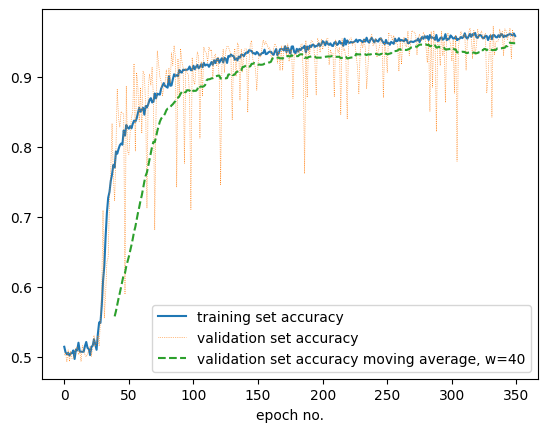

In [26]:
# plot_loss_history(history)
plot_accuracy_history(history, (40,))

In [27]:
make_dataframe(history).to_csv('/host/dissertation/trained_models/history.csv', index=False)
df = pd.read_csv('/host/dissertation/trained_models/history.csv')

tail_size = 20
val_accuracy_tail = df['val_accuracy'][-tail_size:]
accuracy_tail = df['accuracy'][-tail_size:]
print('-------------')
print('val_accuracy')
print(f'   avg: {np.average(val_accuracy_tail):.6f}')
print(f'   med: {np.median(val_accuracy_tail):.6f}')
print(f'   std: {np.std(val_accuracy_tail):.6f}')
print('accuracy')
print(f'   max: {np.max(accuracy_tail):.6f}')
print(f'   min: {np.min(accuracy_tail):.6f}')
print('-------------\n')


-------------
val_accuracy
   avg: 0.950214
   med: 0.958384
   std: 0.027926
accuracy
   max: 0.962204
   min: 0.954093
-------------



### space search

In [8]:
TAIL_SIZE = 20
EPOCHS_NUM = 250 # 30
hiddenlayers_number_space = [1,2,3]
layer_neurons_number_space = [32,64,96]
layer_activation_func_space = ['pol_tanh','pol_sigmoid','cart_tanh','cart_sigmoid','cart_relu',] #['cart_relu']#

import itertools
hp_list = list(itertools.product(hiddenlayers_number_space,layer_neurons_number_space,layer_activation_func_space))
param = {'hidden_layers': 0, 'neurons_num': 1, 'activation_func': 2}

In [5]:
import os 
import time

TIMESTAMP = int(time.time())
WORKING_DIRECTORY = f'/host/dissertation/trained_models/{TIMESTAMP}/'
os.umask(0)
os.mkdir(WORKING_DIRECTORY, mode=0o777)

import csv
HP_FILEPATH = WORKING_DIRECTORY + 'q_hp.csv'
with open(HP_FILEPATH, 'w', newline='', opener=lambda path, flags: os.open(path, flags, 0o777)) as f:
    hp_file_columns = ['hp_config','time','val_acc-avg','val_acc-med','val_acc-std','train_acc-max','train_acc-min']
    csv.writer(f).writerow(hp_file_columns)

In [10]:
def hp_string(config):
    return str(config).translate(str.maketrans(',','-'," '()"))
def get_history_filename(config):
    return hp_string(config) + '-history.csv'

get_history_filename((1, 32, 'cart_relu'))

'1-32-cart_relu-history.csv'

In [11]:
def append_hp_file(hp_config, df):
    val_accuracy_tail = df['val_accuracy'][-TAIL_SIZE:]
    accuracy_tail = df['accuracy'][-TAIL_SIZE:]
    
    with open(HP_FILEPATH, 'a', newline='') as f:
        csv.writer(f).writerow([hp_string(hp_config),time.strftime("%H:%M:%S", time.localtime()),np.average(val_accuracy_tail),np.median(val_accuracy_tail),np.std(val_accuracy_tail),np.max(accuracy_tail),np.min(accuracy_tail)])

In [12]:
import cvnn.layers as complex_layers

for hp in hp_list:
    print('START', hp)
    model = tf.keras.models.Sequential()
    model.add(complex_layers.ComplexInput(input_shape=(POINTS_NUM,)))
    for layer_no in range(hp[param['hidden_layers']]):
        model.add(complex_layers.ComplexDense(units=hp[param['neurons_num']], activation=hp[param['activation_func']]))
    model.add(complex_layers.ComplexDense(units=CLASSES_NUM, activation='sigmoid_real'))
    model.compile(optimizer=tf.keras.optimizers.SGD(clipnorm=1.), loss='binary_crossentropy', metrics=['accuracy'])
    print('      model compiled')
    print('      training...')
    history = model.fit(points, q_labels, epochs=EPOCHS_NUM, validation_split=0.2, verbose=0, callbacks=[FreeMemory()])
    print('      model trained')
    df = make_dataframe(history)
    append_hp_file(hp, df)
    print('      hp_file appended')
    df.to_csv(WORKING_DIRECTORY + get_history_filename(hp), index=False)
    print('      history saved')
    print('DONE ', hp)

START (1, 32, 'pol_tanh')
      model compiled
      training...


2023-11-01 18:19:18.427996: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f970af8b480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-01 18:19:18.428017: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-11-01 18:19:18.513089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-01 18:19:18.544650: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      model trained
      hp_file appended
      history saved
DONE  (1, 32, 'pol_tanh')
START (1, 32, 'pol_sigmoid')
      model compiled
      training...


## sparse_categorical_crossentropy

In [ ]:
# import cvnn.layers as complex_layers

# model = tf.keras.models.Sequential()
# model.add(complex_layers.ComplexInput(input_shape=(POINTS_NUM,)))
# model.add(complex_layers.ComplexDense(units=64, activation='cart_relu'))
# model.add(complex_layers.ComplexDense(units=CLASSES_NUM, activation='softmax_of_softmax_real_with_avg'))
# model.compile(optimizer=tf.keras.optimizers.SGD(clipnorm=1.), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
# history = model.fit(points, q, epochs=250, validation_split=0.2, verbose=0, callbacks=[FreeMemory(10)])